In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'svg'

from sklearn.metrics import r2_score as r2, mean_squared_error as mse, mean_absolute_error as mae

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

##### Функции для предобработки

In [2]:
def reduction_memory(df: pd.DataFrame):
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    return df_c

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
PATH_TO_FILE = 'my_PJME_MW.csv'
# PATH_TO_FILE = '../input/ml-in-business/my_PJME_MW.csv'

df = pd.read_csv(PATH_TO_FILE) # read scv file
df['DateTime'] = (df['Date'] + ' ' + df['Time']).astype('datetime64') # concat and retype Date and Time
df = df.set_index('DateTime')      # set DateTime in index
# df = reduction_memory(df)          # reduсe size
df_week = df.resample('W').mean()  # resample in weekly data
df_week[:2]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
DateTime,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.0,0.167832
2002-01-13,31487.386905,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.0,0.000000


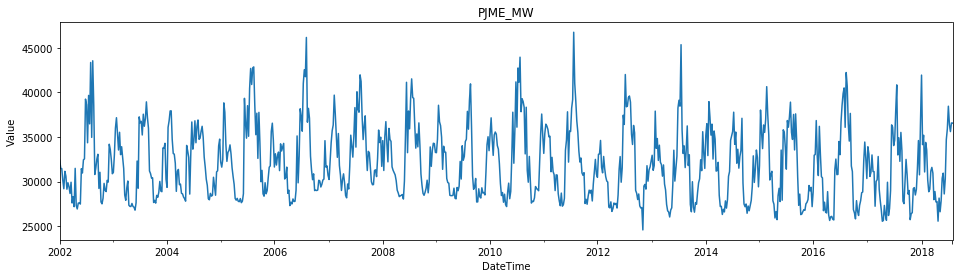

In [4]:
df_week['PJME_MW'].plot(figsize=(16, 4), title='PJME_MW')
plt.ylabel('Value')
plt.show()

### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.

### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

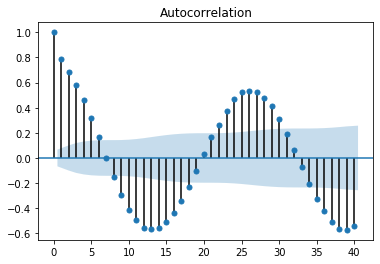

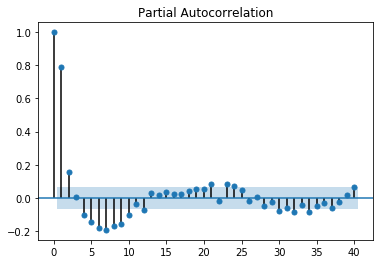

In [5]:
#ACF
sm.graphics.tsa.plot_acf(df_week['PJME_MW'], lags=40)
plt.show()
#PACF
sm.graphics.tsa.plot_pacf(df_week['PJME_MW'], lags=40)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                PJME_MW   No. Observations:                  180
Model:                     ARMA(3, 2)   Log Likelihood               -1648.565
Method:                       css-mle   S.D. of innovations           2250.401
Date:                Tue, 10 Nov 2020   AIC                           3311.131
Time:                        20:53:24   BIC                           3333.482
Sample:                    02-01-2015   HQIC                          3320.193
                         - 07-08-2018                                         
============================================================================== =================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.105e+04    321.065     96.

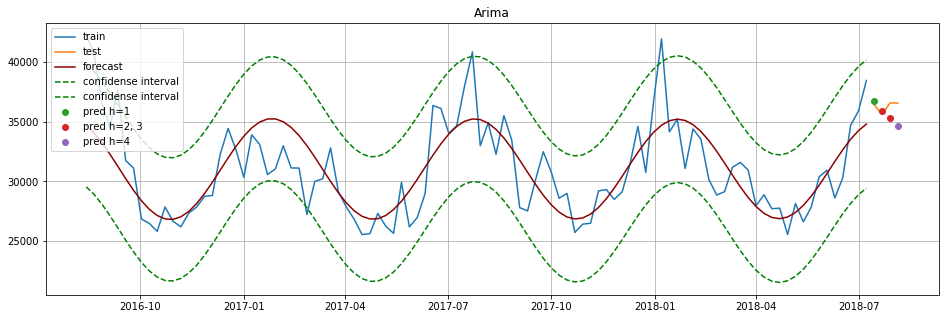

In [6]:
# spliting target
h = 4

y_train = df_week['PJME_MW'][:-h][-180:]
y_test_4 = df_week['PJME_MW'][-h:]

# ARIMA
p, d, q = 3, 0, 2

model_arima = ARIMA(y_train, order=(p, d, q))

result = model_arima.fit(disp=False)

print(result.summary().tables[0], result.summary().tables[1])

# prediction
y_pred = result.predict(start=y_train.shape[0], end=y_train.shape[0]+h-1)

y_forecast = result.forecast(y_train.shape[0])

# plot
N = 100
plt.figure(figsize=(16,5))

# true values
plt.plot(y_train[-N:].index, y_train[-N:], label='train')
plt.plot(y_test_4.index, y_test_4, label='test')
# forecasts
plt.plot(y_train[-N:].index, y_forecast[0][-N:], color='darkred', label='forecast')
plt.plot(y_train[-N:].index, y_forecast[2][-N:], '--g', label='confidense interval')
# preds
plt.plot(y_pred.index[0], y_pred[0], 'o', label='pred h=1')
plt.plot(y_pred.index[1:3], y_pred[1:3], 'o', label='pred h=2, 3')
plt.plot(y_pred.index[3], y_pred[3], 'o', label='pred h=4')

plt.grid()
plt.title('Arima')
plt.legend(loc='upper left')
plt.show()

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    result = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return round(result, 2)

mape = mean_absolute_percentage_error

In [8]:
err = mape(y_test_4, y_pred)

print(f'Проценты ошибки в предсказынных значениях = {err}%')

Проценты ошибки в предсказынных значениях = 2.59%


### 4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [9]:
def train_test_split(X, y, date):
    """function for spliting data"""
    
    X_train = X[X.index < date]
    X_test = X[X.index >= date]
    
    y_train = y[y.index < date]
    y_test = y[y.index >= date]
    
    return X_train, X_test, y_train, y_test

In [10]:
def evaluate_pred(train_true, train_pred, test_true, test_pred):
    """
    function for evaluate prediction: 
    
        scatter: true, prediction,
        plot: true, prediction,
        calculates: R2, MSE, MAE
    """
    
    err_r2_train = round(r2(train_true, train_pred), 2)
    err_mse_train = round(mse(train_true, train_pred), 2)
    err_mae_train = round(mae(train_true, train_pred), 2)
    
    err_r2_test = round(r2(test_true, test_pred), 2)
    err_mse_test = round(mse(test_true, test_pred), 2)
    err_mae_test = round(mae(test_true, test_pred), 2)
    
    diff_r2 = round(((err_r2_train - err_r2_test)**2)**(1/2), 2)
    diff_mse = round(((err_mse_train - err_mse_test)**2)**(1/2), 2)
    diff_mae = round(((err_mae_train - err_mae_test)**2)**(1/2), 2)
    
    print(f'Train errors:\n\n', 
          f'\tR2 = {err_r2_train}\n', 
          f'\tMSE = {err_mse_train}\n', 
          f'\tMAE = {err_mae_train}\n')
    
    print(f'Test errors:\n\n', 
          f'\tR2 = {err_r2_test}\n', 
          f'\tMSE = {err_mse_test}\n', 
          f'\tMAE = {err_mae_test}\n')
    
    print(f'Error differense:\n\n', 
          f'\tR2 diff = {diff_r2}\n', 
          f'\tMSE diff = {diff_mse}\n', 
          f'\tMAE diff = {diff_mae}\n')
    
    fig, ax = plt.subplots(nrows=2, ncols=2)
    
    ax1, ax2, ax3, ax4 = ax.flatten()
    
    # Train
    ax1.scatter(train_true, train_pred)
    ax1.set_xlabel('true')
    ax1.set_ylabel('pred')
    ax1.set_title('Train scatter - True x Pred')
    
    ax2.plot(train_true.index, train_true, label='true')
    ax2.plot(train_true.index, train_pred, label='pred')
    ax2.set_xlabel('date')
    ax2.set_ylabel('value')
    ax2.set_title('Train cmpare - True and Pred')
    
    # Test
    ax3.scatter(test_true, test_pred)
    ax3.set_xlabel('true')
    ax3.set_ylabel('pred')
    ax3.set_title('Test scatter - True x Pred')
    
    ax4.plot(test_true.index, test_true, label='true')
    ax4.plot(test_true.index, test_pred, label='pred')
    ax4.set_xlabel('date')
    ax4.set_ylabel('value')
    ax4.set_title('Test cmpare - True and Pred')
    
    plt.legend()
    
    fig.set_size_inches(24, 10)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [12]:
def featuring(df):
    # rolling
    df['d_w7'] = df['PJME_MW'].rolling(window=4).mean()
    df = df[6:]

    # diff
#     first_diff_l = np.log(df.iloc[1:,0].values) 

#     df['diff1_l'] = 0
#     df['diff1_l'] =  df['diff1_l'].astype('float') 
#     df['diff1_l'].values[1:] = first_diff_l

    # exp
    for i in range(1,9):
        df[f'exp_0_0{i}'] = exponential_smoothing(df['PJME_MW'], i*0.01)
        
    return df

In [13]:
# featuring
df_week = featuring(df_week)

Train errors:

 	R2 = 0.87
 	MSE = 1973836.38
 	MAE = 1046.49

Test errors:

 	R2 = 0.78
 	MSE = 3665263.42
 	MAE = 1509.75

Error differense:

 	R2 diff = 0.09
 	MSE diff = 1691427.04
 	MAE diff = 463.26



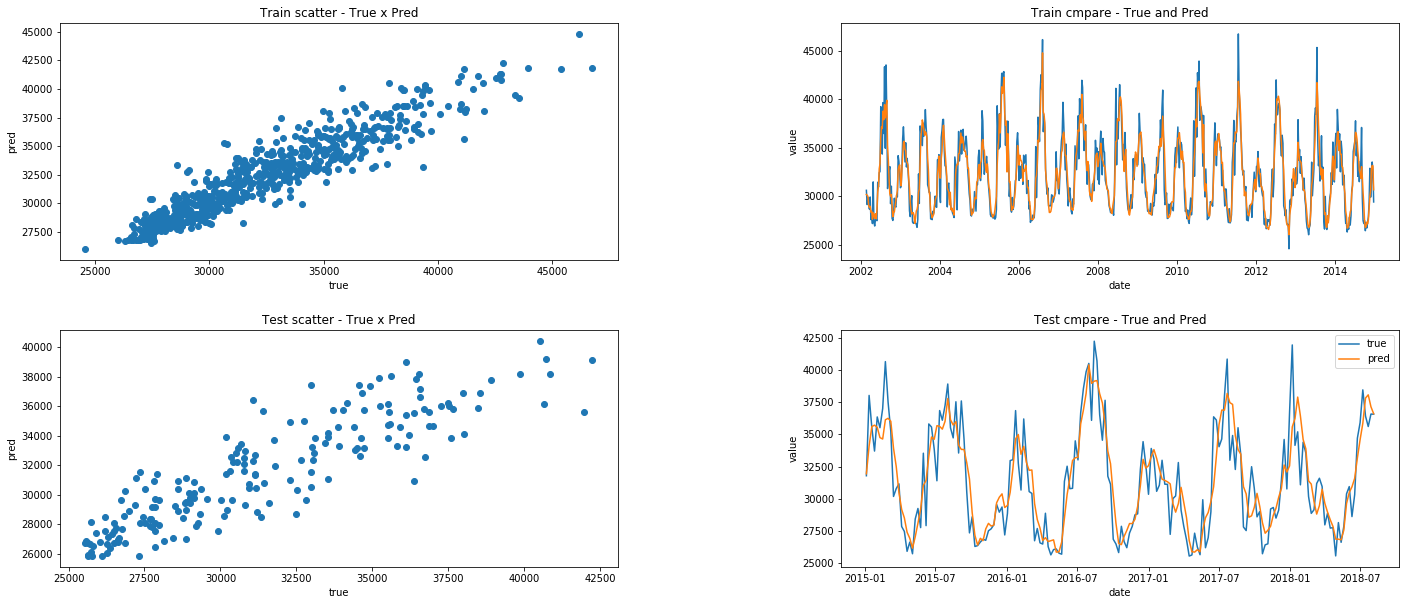

In [14]:
# best model

# spliting data
X = df_week.drop('PJME_MW', axis=1)
y = df_week['PJME_MW']

X_train, X_test, y_train, y_test = train_test_split(X, y, date='01-01-2015')

# learn gbr
model_gbr = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, n_estimators=580, random_state=42)
model_gbr.fit(X_train, y_train)

# prediction
y_train_pred = model_gbr.predict(X_train)
y_test_pred = model_gbr.predict(X_test)

evaluate_pred(train_true=y_train, train_pred=y_train_pred, 
              test_true=y_test, test_pred=y_test_pred)

In [15]:
def recursion_model(X, y, p):
    X_test_с = X.copy()
    y_pred_с = y.copy()

    for i in range(p, 0, -1):
        # predict
        y_pred_с[-i] = model_gbr.predict(X_test_с.iloc[[-i]])

        # vector
        y_pred_с[-i+1] = (y_pred_с[-i] - y_pred_с.mean()) / (y_test_pred.var())**(1/2)

        # features
        X_test_с['d_w7'][-i+1] = (y_pred_с[-i-3:-i+1]).mean()

        for j in range(1,9):
            alpha = j*0.01
            X_test_с[f'exp_0_0{j}'][-i+1] = X_test_с[f'exp_0_0{j}'][-i]*(1-alpha)+ alpha * y_pred_с[-i+1]
    
    # plot
    plt.figure(figsize=(16, 5))

    plt.plot(y_test[-N:].index, y_test.values[-N:], c='black', label='True')
    plt.plot(y_test[-N:].index, y_test_pred[-N:], 'b', label='pred GB')
    plt.plot(y_test[-N:].index, y_pred_с[-N:], 'og', label='slide')

    plt.xlabel('Время')
    plt.ylabel('Потребление энергии, МВт')

    plt.legend()
    plt.show()
    
    return y_pred_с

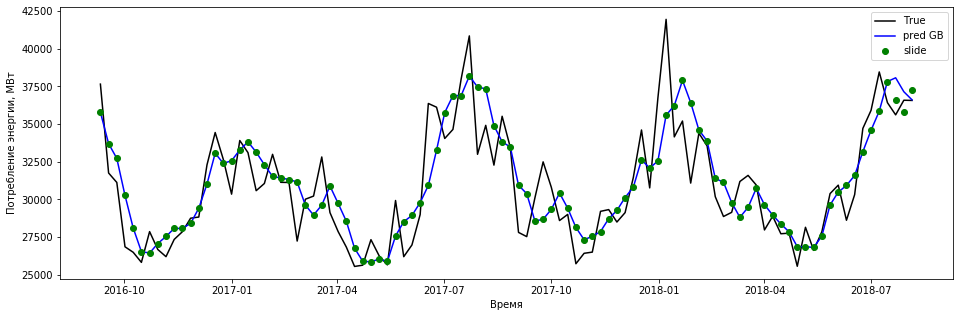

Проценты ошибки в предсказынных значениях = 2.33%


In [16]:
h = 4

y_pred_c = recursion_model(X=X_test, y=y_test_pred, p=h)

err_rec = mape(y_test_pred[-h:], y_pred_c[-h:])

print(f'Проценты ошибки в предсказынных значениях = {err_rec}%')

In [17]:
round(err - err_rec, 2)

0.26

##### Вывод: при рекурсивном моделировании ошибка несколько уменьшилась по сравнению с прямым моделированием, разница в точности при моделировании дальностью на 1 месяц вперед = 0.26%.

### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах: 
### от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... , 
### от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

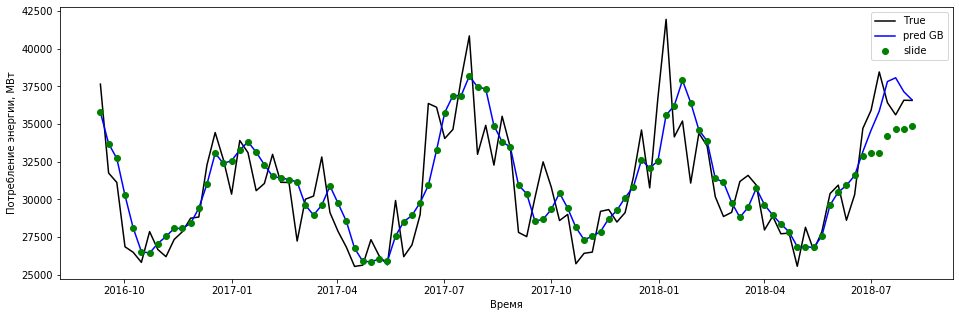

Проценты ошибки в предсказынных значениях при p = 8 - 5.37%


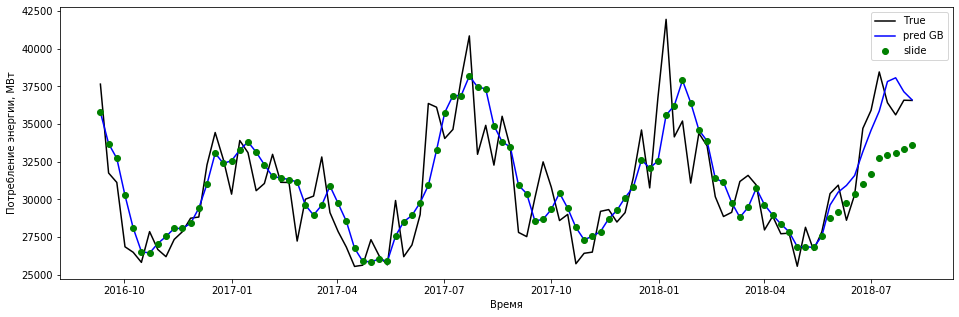

Проценты ошибки в предсказынных значениях при p = 12 - 6.89%


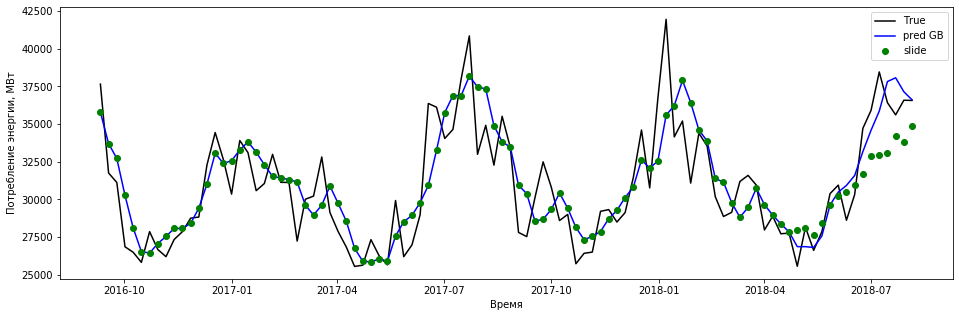

Проценты ошибки в предсказынных значениях при p = 16 - 4.58%


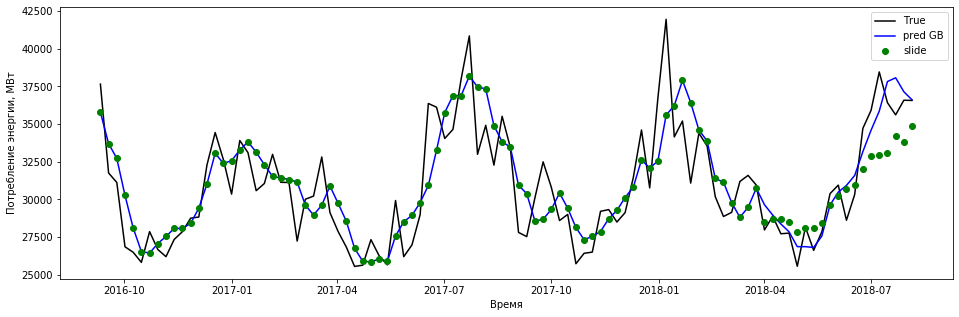

Проценты ошибки в предсказынных значениях при p = 20 - 4.05%


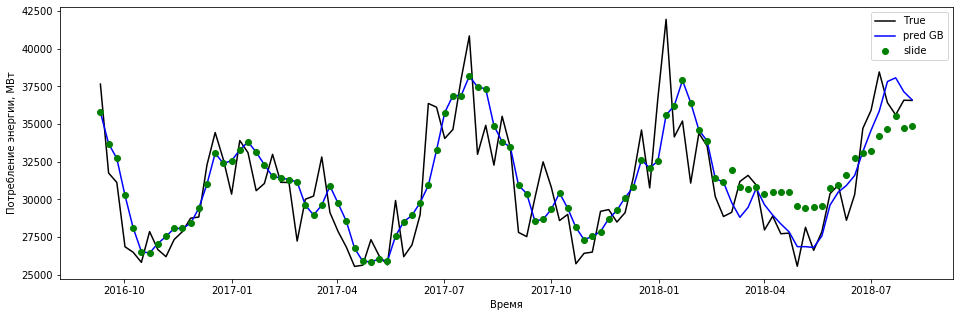

Проценты ошибки в предсказынных значениях при p = 24 - 5.26%


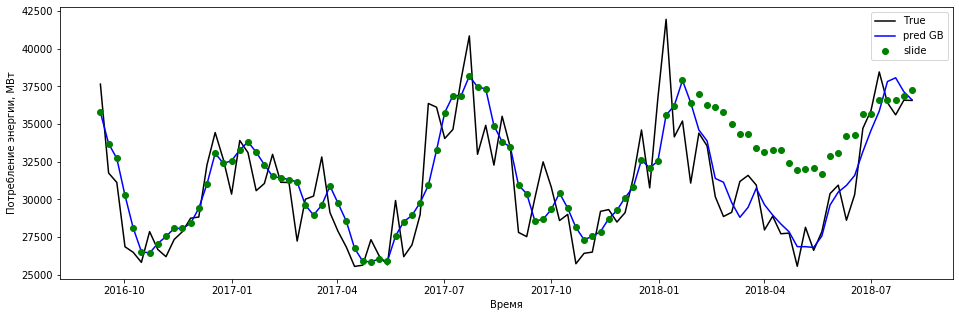

Проценты ошибки в предсказынных значениях при p = 28 - 10.72%


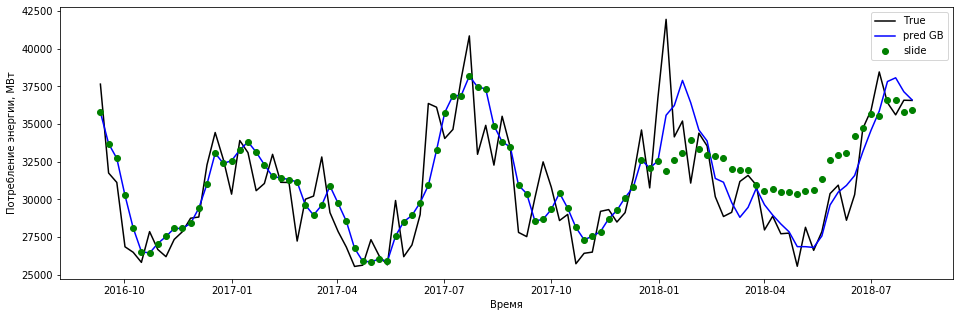

Проценты ошибки в предсказынных значениях при p = 32 - 6.85%


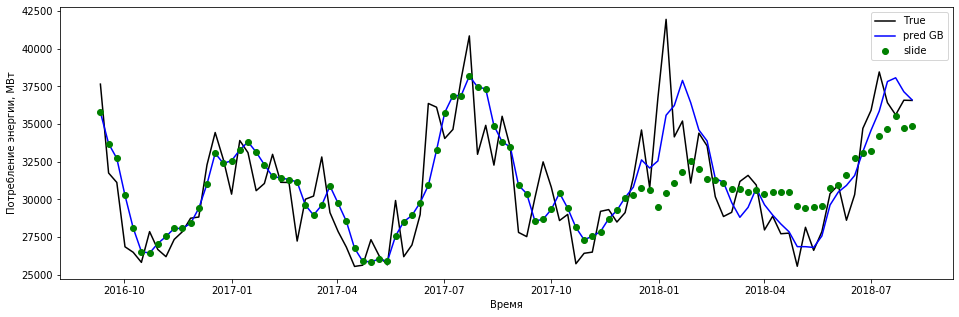

Проценты ошибки в предсказынных значениях при p = 36 - 5.93%


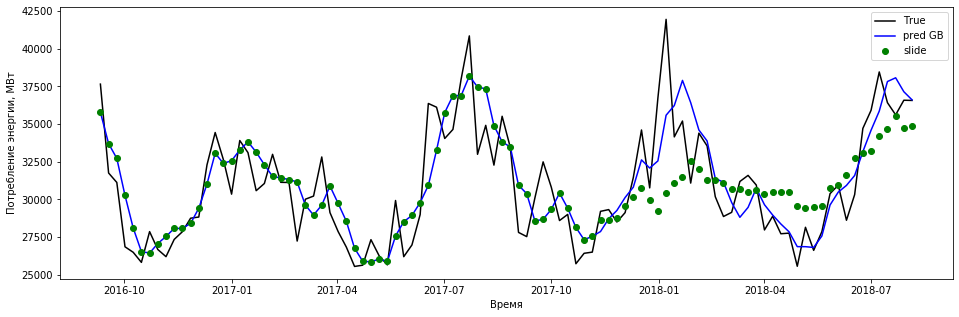

Проценты ошибки в предсказынных значениях при p = 40 - 5.62%


In [18]:
coef = list(range(2, 11))
err_list = []

for ip in coef:
    
    p = 4*ip
    
    y_pred_c = recursion_model(X=X_test, y=y_test_pred, p=p)

    err_rec = mape(y_test_pred[-p:], y_pred_c[-p:])
    
    err_list.append(err_rec)

    print(f'Проценты ошибки в предсказынных значениях при p = {p} - {err_rec}%')

### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

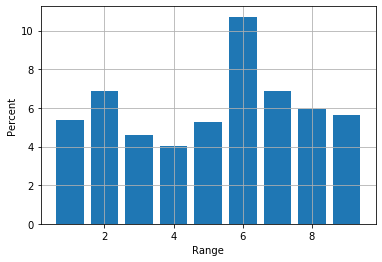

In [19]:
plt.bar(range(1, len(err_list)+1), err_list)

plt.ylabel('Percent')
plt.xlabel('Range')
plt.grid()
plt.show()

##### Вывод: на графике видно, что поведение ишибки не обязательно растет, но может варьироваться.